## Aluno: Fernando Gomes Papi

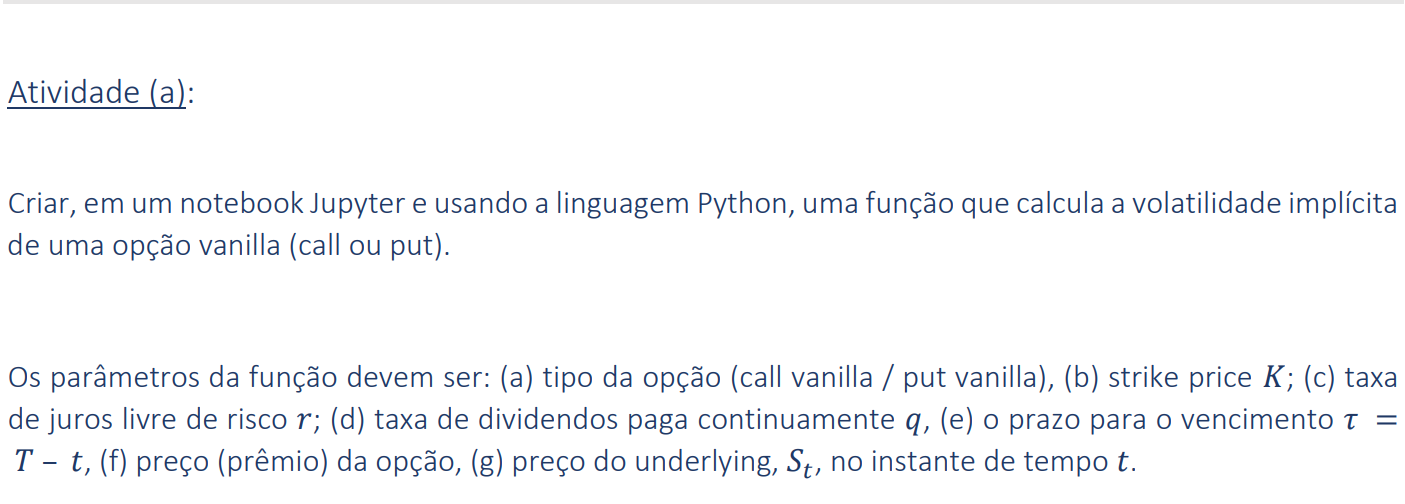

Cálculo da volatilidade implícita utilizando Newton-Raphson

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
def black_scholes_pricing_option(r, S, K, T, sigma, q, option_type):

    "Calcula o preço de opção Black-Scholes para call/put"
    # Cálculo dos valores d1 e d2
    d1 = (np.log(S/K) + (r-q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == "call":
        # Cálculo do preço da opção de compra
        price = np.exp(-r*T) * (S*np.exp((r-q)*T) * norm.cdf(d1, 0, 1) - K*norm.cdf(d2, 0, 1))
    
    elif option_type == "put":
        # Cálculo do preço da opção de venda
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)

    return price

def vega_calc(S, K, r, sigma, T):
    # print(sigma)
    # Calcula a derivada do preço da opção em relação à volatilidade (Vega) usando a fórmula de Black-Scholes
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    vega = S * norm.pdf(d1, 0, 1) * np.sqrt(T)
    
    return vega 

In [8]:
# Function to calculate implied volatility using the Newton-Raphson method
def implied_volatility(r, S, K, T, q, option_type, market_price):
    '''Calculate implied volatility using Newton-Raphson'''
    max_tries = 300  # Maximum number of iterations for convergence
    sigma = 0.5  # Initial guess for implied volatility
        
    for i in range(max_tries):
        if sigma <= 1e-5:
            return 0  # Implied volatility is 0 when it becomes too small

        # Calculate the Black-Scholes option price using the current sigma
        _bs_price = black_scholes_pricing_option(r, S, K, T, sigma, q, option_type)
        
        # Calculate the difference between the market price and the calculated Black-Scholes price
        diff = market_price - _bs_price
        
        # Calculate the derivative (vega) with respect to sigma
        vega = vega_calc(S, K, r, sigma, T)
        
        if abs(diff) < 1e-5:
            return sigma  # If the difference is small enough, return the calculated implied volatility
        
        # Update the sigma value using the Newton-Raphson method
        sigma += diff / vega
        
    return sigma  # If convergence is not reached, return the last calculated sigma


In [9]:
# Define variáveis - exemplo de John Hull
S = 21
r = 0.1  # Taxa de juros
K = 20  # Preço de exercício
T = 1  # Maturidade da opção
sigma = 0.2345
lambda_ = 0
beta_Y = 0 #Mean jump size
sigma_Y = 0 #Standard deviation of the jump size

div_yield = 0.00  # Rendimento por dividendos
black_scholes_pricing_option(r, S, K, T, sigma, div_yield, 'call')

3.6292371398841565

In [10]:
# Define variáveis - exemplo de John Hull
S = 21
r = 0.1  # Taxa de juros
K = 20  # Preço de exercício
T = 0.25  # Maturidade da opção
div_yield = 0.00  # Rendimento por dividendos

iv = implied_volatility(r, S, K, T, q=div_yield, 
                        option_type='call', market_price=1.875)
print(f'Volatilidade Implícita: {iv*100 :.2f} %')

Volatilidade Implícita: 23.45 %


In [13]:
from math import factorial

def merton_jump_diffusion_option(S, K, r, q, sigma, T, lambda_, beta_Y, sigma_Y, option_type="call"):
    """
    Calculate the price of a European option using the Merton Jump Diffusion model.

    Parameters:
    S (float): Current price of the underlying asset
    K (float): Strike price of the option
    r (float): Risk-free interest rate
    q (float): Dividend yield
    sigma (float): Volatility of the underlying asset
    T (float): Time to maturity of the option
    lambda_ (float): Intensity of the Poisson process governing the jump arrivals
    beta_Y (float): Mean jump size
    sigma_Y (float): Standard deviation of the jump size
    option_type (str): Type of the option: "call" or "put"

    Returns:
    float: Price of the option
    """

    # Calculate the jump parameters
    kappa = np.exp(beta_Y + 0.5 * sigma_Y**2) - 1
    lambda_R = lambda_ * (1 + kappa)
    
    Vt = 0
    lim = int(4 * (lambda_ * T))
    jump_term = 0
    
    for k in range(lim + 1):
        # Calculate the risk-neutral parameters for each jump state
        r_n = r - lambda_ * kappa + (k / T) * (beta_Y + 0.5 * sigma_Y**2)
        sigma_n = np.sqrt(sigma**2 + (k / T) * sigma_Y**2)
        
        # Calculate the probability of k jumps using the Poisson distribution
        poisson_prob = np.exp(-lambda_R * T) * (lambda_R * T)**k / factorial(k)
        
        # Calculate the Black-Scholes price with the adjusted parameters
        BnS_price = black_scholes_pricing_option(r_n, S, K, T, sigma_n, q, option_type)
        
        # Accumulate the option price considering all possible jump states
        Vt += poisson_prob * BnS_price
    
    return Vt


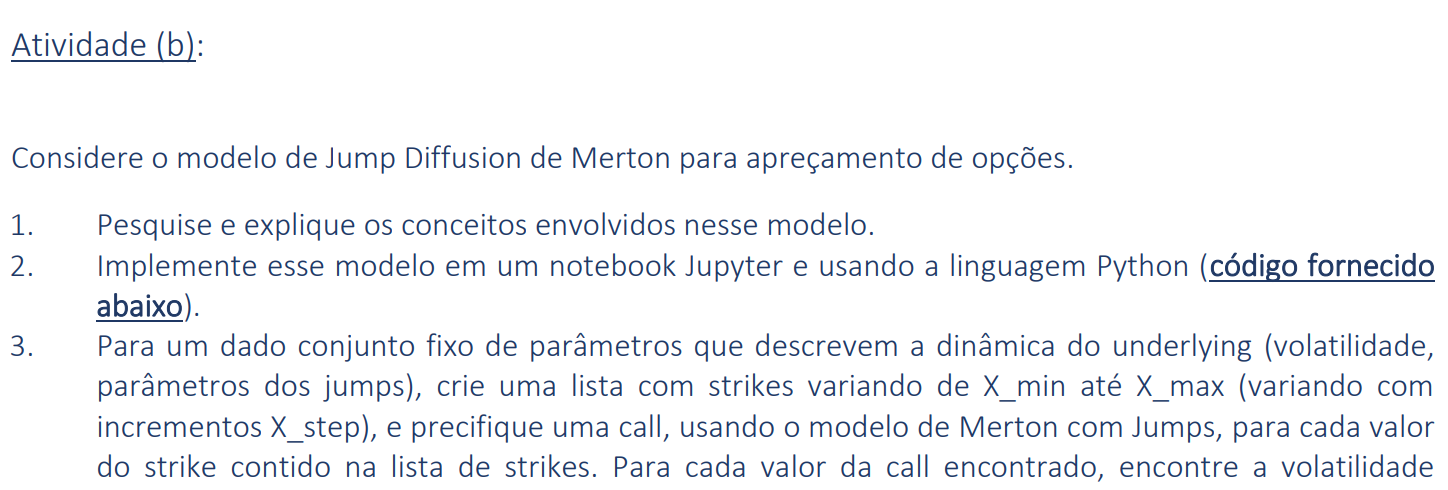
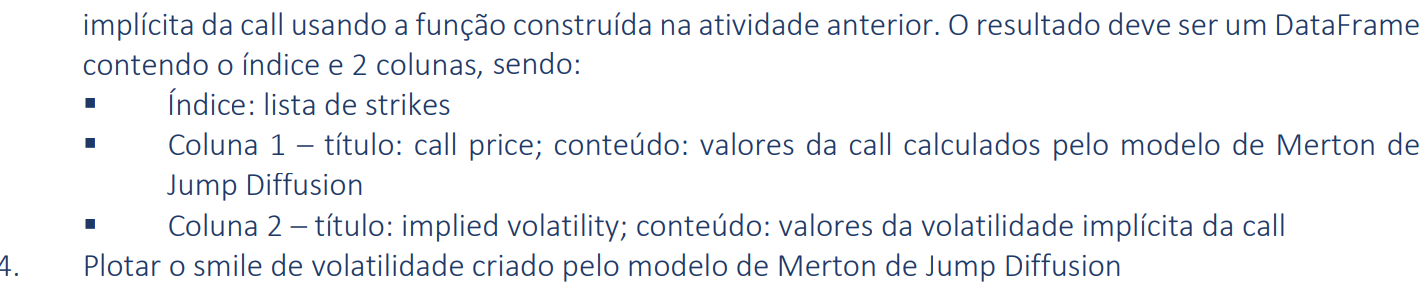

Este modelo é uma extensão do modelo de Black Scholes para levar em conta saltos no preço do ativo subjacente. 

O modelo ainda leva em conta um movimento browniano geométrico, com volatilidade constante, porém adiciona uma modelagem por um Processo de Poisson para descrever a possibilidade de saltos de intensidade aleatória e frequência irregular. 

A volatilidade deste modelo é composta pela volatilidade do processo do ativo subjacente mais a volatilidade dos saltos.

Devido a estes saltos aleatórios, o cálculo da volatilidade implícita a partir do Modelo de Black Scholes apresenta o 'Smile de Volatilidade', uma variação que se aproxima mais do comportamento real do mercado, onde as opções fora do dinheiro (OTM) podem ter volatilidades implícitas mais altas do que as opções no dinheiro (ITM).

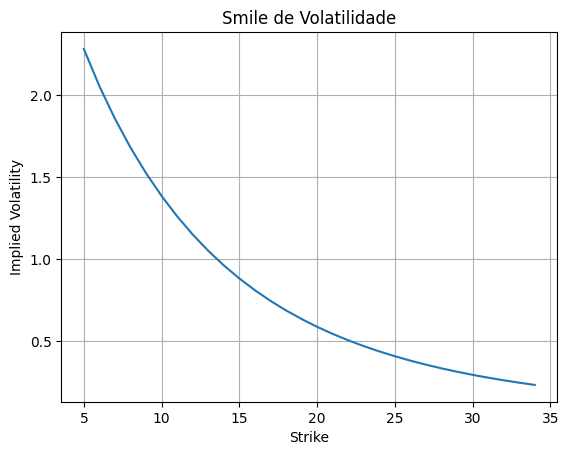

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define variáveis - exemplo de John Hull
S = 18
r = 0.1  # Taxa de juros
T = 1  # Maturidade da opção
sigma = 0.2345
lambda_ = 4
beta_Y = 0.25  # Mean jump size
sigma_Y = 0.03  # Standard deviation of the jump size
div_yield = 0.03  # Rendimento por dividendos
strikes = np.arange(5, 35)

# Função para calcular volatilidades implícitas
def calculate_implied_volatilities(strikes, S, K, r, div_yield, sigma, T, lambda_, beta_Y, sigma_Y, option_type):
    # Calcula os preços das opções de compra (calls) para diferentes strikes
    call_prices = [merton_jump_diffusion_option(S, K, r, div_yield, sigma, T, 
                                                lambda_, beta_Y, 
                                                sigma_Y, option_type="call") 
                   for K in strikes]
    
    # Calcula as volatilidades implícitas para os preços das opções
    iv = [implied_volatility(r, S, K, T, q=div_yield, 
                             option_type='call', market_price=call_p) 
          for call_p in call_prices]
    
    # Cria um DataFrame com os resultados
    data = {
        "Call Price": call_prices,
        "Implied Volatility": iv
    }
    
    df = pd.DataFrame(data, index=strikes)
    return df

# Calcula as volatilidades implícitas e cria um DataFrame
df = calculate_implied_volatilities(strikes, S, K, r, div_yield, sigma, T, 
                                    lambda_, beta_Y, sigma_Y, option_type='call')

# Plota o smile de volatilidade
plt.plot(df.index, df["Implied Volatility"])
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Smile de Volatilidade")
plt.grid()
plt.show()
